In [ ]:
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
from tensorflow.keras.models import load_model


mnistnd = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/mnistnd')

mnistminimal = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/mnistminimal')


mnistnd.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mnistminimal.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = np.expand_dims(x_train, -1), np.expand_dims(x_test, -1)
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Define a function to create adversarial examples using FGSM
def fgsm(image, label, model, epsilon):
    image = tf.convert_to_tensor(image, dtype=tf.float64)
    label = tf.convert_to_tensor(label, dtype=tf.float64)
    image = tf.expand_dims(image, 0)
    label = tf.expand_dims(label, 0)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_gradient = tf.sign(gradient)
    adv_image = image + epsilon * signed_gradient
    adv_image = tf.clip_by_value(adv_image, 0, 1)
    return adv_image[0].numpy()


In [ ]:


# Generate adversarial examples for the test dataset
epsilons = np.linspace(0.0, 0.1, num=20)
epsilons = epsilons.tolist()

acc_nd = []

loss_nd = []

for epsilon in epsilons:
    # Generate adversarial examples for the test dataset
    adv_x_test = []
    for img, label in zip(x_test, y_test):
        adv_x_test.append(fgsm(img, label, mnistnd, epsilon))
    adv_x_test = np.array(adv_x_test)

    # Evaluate the model's performance on the adversarial examples
    adv_loss, adv_accuracy = mnistnd.evaluate(adv_x_test, y_test, verbose=1)

    acc_nd.append(adv_accuracy)
    loss_nd.append(adv_loss)
    print(f"Epsilon: {epsilon}")
    print("Adversarial Test Loss:", adv_loss)
    print("Adversarial Test Accuracy:", adv_accuracy)
    print()

313/313 [==============================] - 1s 2ms/step - loss: 0.5865 - accuracy: 0.9848
Epsilon: 0.0
Adversarial Test Loss: 0.5865223407745361
Adversarial Test Accuracy: 0.9847999811172485

313/313 [==============================] - 1s 2ms/step - loss: 0.7571 - accuracy: 0.9793
Epsilon: 0.005263157894736842
Adversarial Test Loss: 0.7571428418159485
Adversarial Test Accuracy: 0.9793000221252441

313/313 [==============================] - 1s 2ms/step - loss: 0.9644 - accuracy: 0.9755
Epsilon: 0.010526315789473684
Adversarial Test Loss: 0.9644330143928528
Adversarial Test Accuracy: 0.9754999876022339

313/313 [==============================] - 1s 2ms/step - loss: 1.1945 - accuracy: 0.9714
Epsilon: 0.015789473684210527
Adversarial Test Loss: 1.1945375204086304
Adversarial Test Accuracy: 0.9714000225067139

313/313 [==============================] - 1s 2ms/step - loss: 1.4581 - accuracy: 0.9654
Epsilon: 0.021052631578947368
Adversarial Test Loss: 1.4581495523452759
Adversarial Test Accurac

In [ ]:
acc_minimal =[]
loss_minimal =[]


for epsilon in epsilons:
    # Generate adversarial examples for the test dataset
    adv_x_test = []
    for img, label in zip(x_test, y_test):
        adv_x_test.append(fgsm(img, label, mnistminimal, epsilon))
    adv_x_test = np.array(adv_x_test)

    # Evaluate the model's performance on the adversarial examples
    adv_loss_minimal, adv_accuracy_minimal = mnistminimal.evaluate(adv_x_test, y_test, verbose=0)
    acc_minimal.append(adv_accuracy_minimal)
    loss_minimal.append(adv_loss_minimal)

    print(f"Epsilon: {epsilon}")
    print("Adversarial Test Loss:", adv_loss_minimal)
    print("Adversarial Test Accuracy:", adv_accuracy_minimal)
    print()





Epsilon: 0.0
Adversarial Test Loss: 0.21136921644210815
Adversarial Test Accuracy: 0.9804999828338623

Epsilon: 0.005263157894736842
Adversarial Test Loss: 0.3185490369796753
Adversarial Test Accuracy: 0.9710000157356262

Epsilon: 0.010526315789473684
Adversarial Test Loss: 0.47278687357902527
Adversarial Test Accuracy: 0.9575999975204468

Epsilon: 0.015789473684210527
Adversarial Test Loss: 0.6893126964569092
Adversarial Test Accuracy: 0.9398999810218811

Epsilon: 0.021052631578947368
Adversarial Test Loss: 0.9653202295303345
Adversarial Test Accuracy: 0.9261999726295471

Epsilon: 0.02631578947368421
Adversarial Test Loss: 1.2858905792236328
Adversarial Test Accuracy: 0.9118000268936157

Epsilon: 0.031578947368421054
Adversarial Test Loss: 1.6688743829727173
Adversarial Test Accuracy: 0.8870000243186951

Epsilon: 0.03684210526315789
Adversarial Test Loss: 2.1460793018341064
Adversarial Test Accuracy: 0.8522999882698059

Epsilon: 0.042105263157894736
Adversarial Test Loss: 2.7452507019

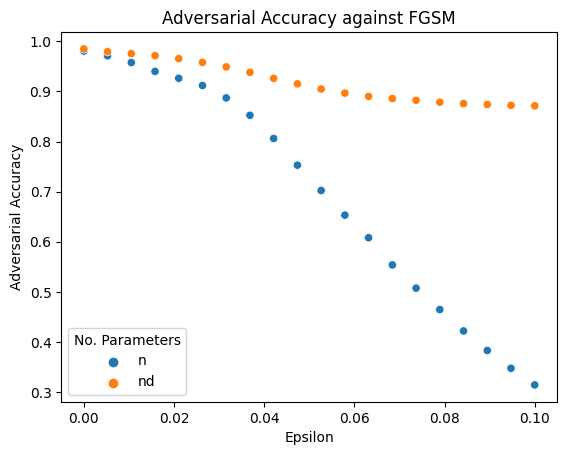

In [ ]:
data = pd.DataFrame({ 'n': acc_minimal, 'nd': acc_nd, 'epsilon': epsilons })

data_melted = data.melt(id_vars='epsilon', var_name='No. Parameters', value_name='Adversarial Accuracy')

sns.scatterplot(data=data_melted, y='Adversarial Accuracy', x='epsilon', hue='No. Parameters')

plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.title('Adversarial Accuracy against FGSM')

plt.show()

In [ ]:
def white_noise_attack(images, noise_scale):
    noisy_images = []
    for img in images:
        noise = np.random.normal(0, noise_scale, img.shape)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, 0, 1)  # Clip values to be between 0 and 1
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

noise_acc_nd = []

noise_loss_nd = []

epsilons = np.linspace(0.0, 0.5, num=20)
epsilons = epsilons.tolist()



In [ ]:

for epsilon in epsilons:
  # Generate white noise adversarial examples
  noisy_x_test = white_noise_attack(x_test, epsilon)

  # Evaluate the model's performance on the noisy images
  noise_loss, noise_acc = mnistnd.evaluate(noisy_x_test, y_test, verbose=0)
  noise_acc_nd.append(noise_acc)
  noise_loss_nd.append(noise_loss)
  print("Noisy Test Loss:", noise_loss)
  print("Noisy Test Accuracy:", noise_acc)

Noisy Test Loss: 0.5865223407745361
Noisy Test Accuracy: 0.9847999811172485
Noisy Test Loss: 0.5600341558456421
Noisy Test Accuracy: 0.9843999743461609
Noisy Test Loss: 0.5386890769004822
Noisy Test Accuracy: 0.982699990272522
Noisy Test Loss: 0.5277550220489502
Noisy Test Accuracy: 0.9819999933242798
Noisy Test Loss: 0.5377261638641357
Noisy Test Accuracy: 0.9801999926567078
Noisy Test Loss: 0.5638169050216675
Noisy Test Accuracy: 0.975600004196167
Noisy Test Loss: 0.6573334336280823
Noisy Test Accuracy: 0.9700999855995178
Noisy Test Loss: 0.7400528192520142
Noisy Test Accuracy: 0.9606000185012817
Noisy Test Loss: 0.9070685505867004
Noisy Test Accuracy: 0.9502000212669373
Noisy Test Loss: 1.2090134620666504
Noisy Test Accuracy: 0.9273999929428101
Noisy Test Loss: 1.6042207479476929
Noisy Test Accuracy: 0.9010000228881836
Noisy Test Loss: 2.310471773147583
Noisy Test Accuracy: 0.8622999787330627
Noisy Test Loss: 2.8772382736206055
Noisy Test Accuracy: 0.8216999769210815
Noisy Test Loss

In [ ]:
noise_acc_minimal = []

noise_loss_minimal = []

for epsilon in epsilons:
  # Generate white noise adversarial examples
  noisy_x_test = white_noise_attack(x_test, epsilon)

  # Evaluate the model's performance on the noisy images
  noise_loss, noise_acc = mnistminimal.evaluate(noisy_x_test, y_test, verbose=0)
  noise_acc_minimal.append(noise_acc)
  noise_loss_minimal.append(noise_loss)
  print("Noisy Test Loss:", noise_loss)
  print("Noisy Test Accuracy:", noise_acc)

Noisy Test Loss: 0.21136923134326935
Noisy Test Accuracy: 0.9804999828338623
Noisy Test Loss: 0.20849516987800598
Noisy Test Accuracy: 0.9799000024795532
Noisy Test Loss: 0.2161961942911148
Noisy Test Accuracy: 0.9787999987602234
Noisy Test Loss: 0.24431513249874115
Noisy Test Accuracy: 0.9764999747276306
Noisy Test Loss: 0.2894243896007538
Noisy Test Accuracy: 0.9688000082969666
Noisy Test Loss: 0.36944255232810974
Noisy Test Accuracy: 0.955299973487854
Noisy Test Loss: 0.578530490398407
Noisy Test Accuracy: 0.9294000267982483
Noisy Test Loss: 0.8816400170326233
Noisy Test Accuracy: 0.8985000252723694
Noisy Test Loss: 1.4528146982192993
Noisy Test Accuracy: 0.8562999963760376
Noisy Test Loss: 1.9893208742141724
Noisy Test Accuracy: 0.8151000142097473
Noisy Test Loss: 2.792975425720215
Noisy Test Accuracy: 0.7750999927520752
Noisy Test Loss: 3.7440805435180664
Noisy Test Accuracy: 0.7372999787330627
Noisy Test Loss: 4.71093225479126
Noisy Test Accuracy: 0.6912999749183655
Noisy Test Lo

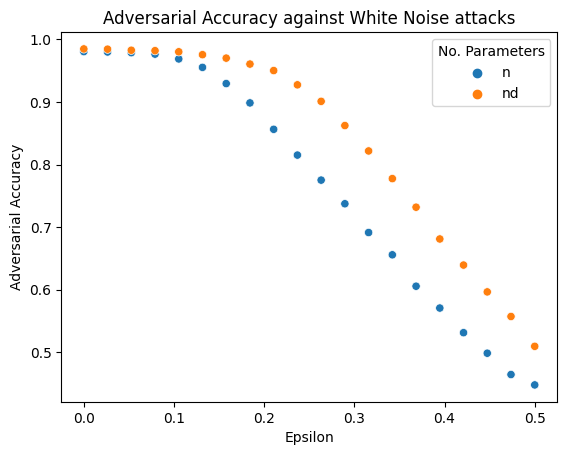

In [ ]:
data = pd.DataFrame({ 'n': noise_acc_minimal, 'nd': noise_acc_nd, 'epsilon': epsilons })

data_melted = data.melt(id_vars='epsilon', var_name='No. Parameters', value_name='Adversarial Accuracy')

sns.scatterplot(data=data_melted, y='Adversarial Accuracy', x='epsilon', hue='No. Parameters')

plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.title('Adversarial Accuracy against White Noise attacks')

plt.show()

1/1 [==============================] - 0s 25ms/step


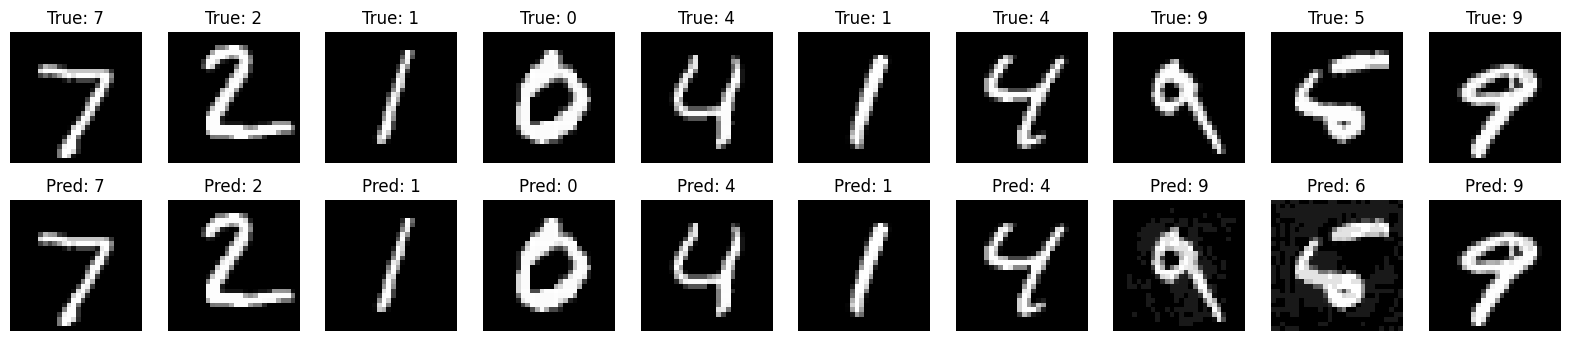

In [ ]:
import matplotlib.pyplot as plt

epsilon = 0.1
num_examples = 10
adv_examples = []
orig_examples = x_test[:num_examples]

for img, label in zip(orig_examples, y_test[:num_examples]):
    adv_img = fgsm(img, label, mnistnd, epsilon)
    adv_examples.append(adv_img)

# Display the original and adversarial examples
fig, axes = plt.subplots(2, num_examples, figsize=(num_examples * 2, 4))

for i, (orig_img, adv_img) in enumerate(zip(orig_examples, adv_examples)):
    adv_prediction = mnistnd.predict(np.expand_dims(adv_img, axis=0))
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(adv_prediction)

    # Display the original image
    axes[0, i].imshow(np.squeeze(orig_img), cmap='gray')
    axes[0, i].set_title(f"True: {true_label}")
    axes[0, i].axis('off')

    # Display the adversarial image
    axes[1, i].imshow(np.squeeze(adv_img), cmap='gray')
    axes[1, i].set_title(f"Pred: {predicted_label}")
    axes[1, i].axis('off')

plt.show()



1/1 [==============================] - 0s 22ms/step


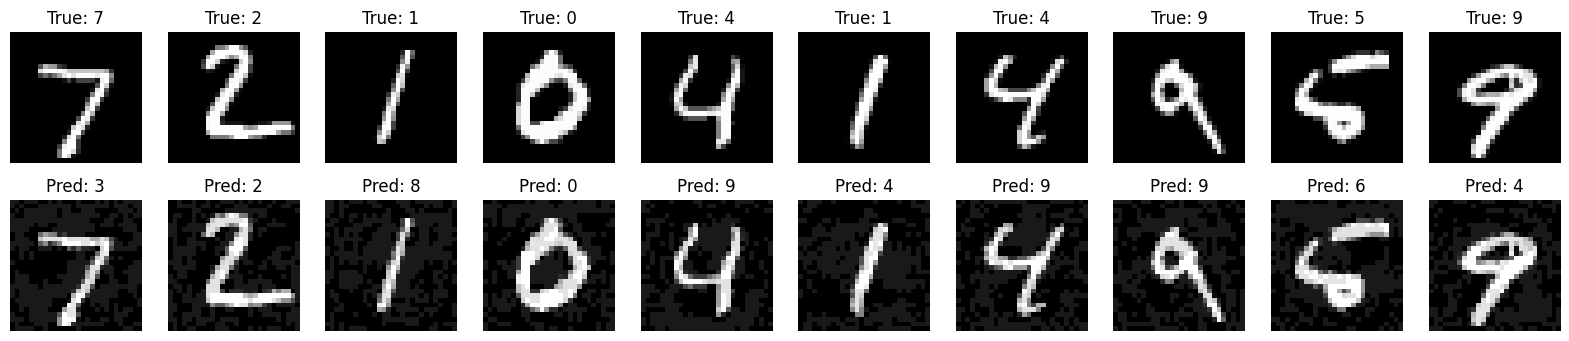

In [ ]:

epsilon = 0.1
num_examples = 10
adv_examples = []
orig_examples = x_test[:num_examples]

for img, label in zip(orig_examples, y_test[:num_examples]):
    adv_img = fgsm(img, label, mnistminimal, epsilon)
    adv_examples.append(adv_img)

# Display the original and adversarial examples
fig, axes = plt.subplots(2, num_examples, figsize=(num_examples * 2, 4))

for i, (orig_img, adv_img) in enumerate(zip(orig_examples, adv_examples)):
    adv_prediction = mnistminimal.predict(np.expand_dims(adv_img, axis=0))
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(adv_prediction)

    # Display the original image
    axes[0, i].imshow(np.squeeze(orig_img), cmap='gray')
    axes[0, i].set_title(f"True: {true_label}")
    axes[0, i].axis('off')

    # Display the adversarial image
    axes[1, i].imshow(np.squeeze(adv_img), cmap='gray')
    axes[1, i].set_title(f"Pred: {predicted_label}")
    axes[1, i].axis('off')

plt.show()

1/1 [==============================] - 0s 23ms/step


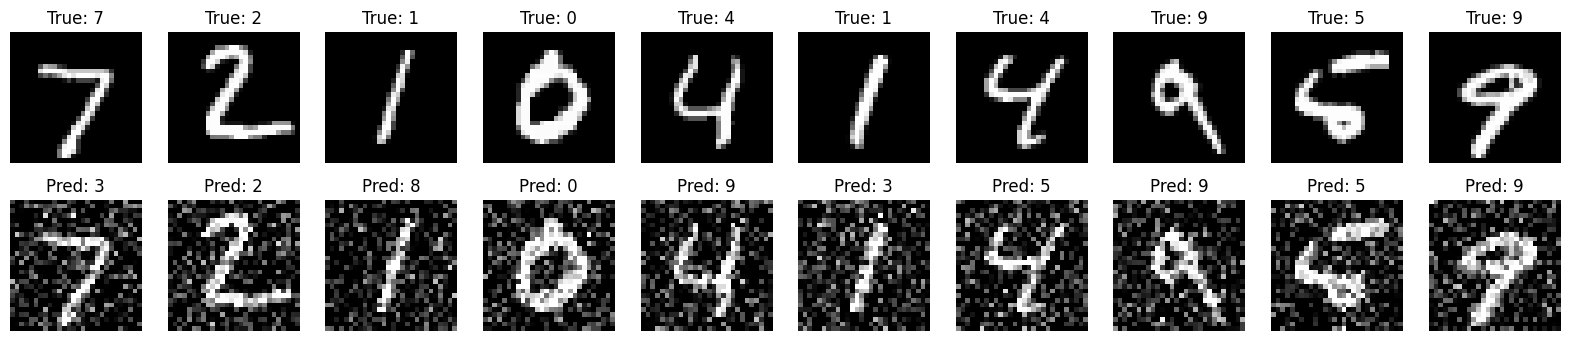

In [ ]:
epsilon = 0.3
num_examples = 10
orig_examples = x_test[:num_examples]
adv_examples = []

for img in orig_examples:
    adv_img = white_noise_attack(img, epsilon)
    adv_examples.append(adv_img)

# Display the original and adversarial examples
fig, axes = plt.subplots(2, num_examples, figsize=(num_examples * 2, 4))

for i, (orig_img, adv_img) in enumerate(zip(orig_examples, adv_examples)):
    adv_prediction = mnistminimal.predict(np.expand_dims(adv_img, axis=0))
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(adv_prediction)

    # Display the original image
    axes[0, i].imshow(np.squeeze(orig_img), cmap='gray')
    axes[0, i].set_title(f"True: {true_label}")
    axes[0, i].axis('off')

    # Display the adversarial image
    axes[1, i].imshow(np.squeeze(adv_img), cmap='gray')
    axes[1, i].set_title(f"Pred: {predicted_label}")
    axes[1, i].axis('off')

plt.show()

1/1 [==============================] - 0s 23ms/step


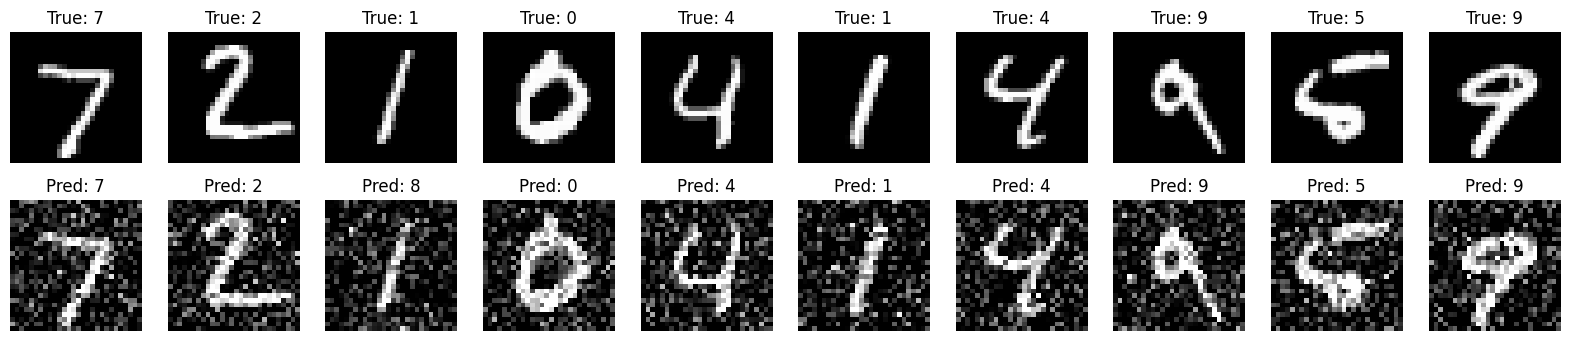

In [ ]:
epsilon = 0.3
num_examples = 10
orig_examples = x_test[:num_examples]
adv_examples = []

for img in orig_examples:
    adv_img = white_noise_attack(img, epsilon)
    adv_examples.append(adv_img)

# Display the original and adversarial examples
fig, axes = plt.subplots(2, num_examples, figsize=(num_examples * 2, 4))

for i, (orig_img, adv_img) in enumerate(zip(orig_examples, adv_examples)):
    adv_prediction = mnistnd.predict(np.expand_dims(adv_img, axis=0))
    true_label = np.argmax(y_test[i])
    predicted_label = np.argmax(adv_prediction)

    # Display the original image
    axes[0, i].imshow(np.squeeze(orig_img), cmap='gray')
    axes[0, i].set_title(f"True: {true_label}")
    axes[0, i].axis('off')

    # Display the adversarial image
    axes[1, i].imshow(np.squeeze(adv_img), cmap='gray')
    axes[1, i].set_title(f"Pred: {predicted_label}")
    axes[1, i].axis('off')
plt.show()

In [ ]:
epsilon = 0.1


# Create FGSM-perturbed images for both models
adv_x_test_nd = [fgsm(img, label, mnistnd, epsilon) for img, label in zip(x_test, y_test)]
adv_x_test_minimal = [fgsm(img, label, mnistminimal, epsilon) for img, label in zip(x_test, y_test)]

# Calculate the L2 norms of the perturbations for each image
norms_nd = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_nd, x_test)]
norms_minimal = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_minimal, x_test)]

# Compute the differences between the norms for each pair of perturbed images
norm_diffs = [norm_nd - norm_minimal for norm_nd, norm_minimal in zip(norms_nd, norms_minimal)]

# Sum the differences
sum_diffs = np.sum(norm_diffs)

print("Sum of the differences of the norms:", sum_diffs)



Sum of the differences of the norms: -17669.597128119814


In [ ]:
epsilon = 0.1

# Create FGSM-perturbed images for both models using only the first 10 images
adv_x_test_nd = [fgsm(img, label, mnistnd, epsilon) for img, label in zip(x_test[:10], y_test[:10])]
adv_x_test_minimal = [fgsm(img, label, mnistminimal, epsilon) for img, label in zip(x_test[:10], y_test[:10])]

# Calculate the L2 norms of the perturbations for each image
norms_nd = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_nd, x_test[:10])]
norms_minimal = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_minimal, x_test[:10])]

# Compute the differences between the norms for each pair of perturbed images
norm_diffs = [norm_nd - norm_minimal for norm_nd, norm_minimal in zip(norms_nd, norms_minimal)]

# Sum the differences
sum_diffs = np.sum(norm_diffs)

print("Sum of the differences of the norms for the first 10 images:", sum_diffs)

Sum of the differences of the norms for the first 10 images: -16.914482637877374


In [ ]:
def fgsm_unclip(image, label, model, epsilon):
    image = tf.convert_to_tensor(image, dtype=tf.float64)
    label = tf.convert_to_tensor(label, dtype=tf.float64)
    image = tf.expand_dims(image, 0)
    label = tf.expand_dims(label, 0)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_gradient = tf.sign(gradient)
    adv_image = image + epsilon * signed_gradient
    return adv_image[0].numpy()

In [ ]:
epsilon = 0.1

# Create FGSM_unclip-perturbed images for both models using only the first 10 images
adv_x_test_nd = [fgsm_unclip(img, label, mnistnd, epsilon) for img, label in zip(x_test[:10], y_test[:10])]
adv_x_test_minimal = [fgsm_unclip(img, label, mnistminimal, epsilon) for img, label in zip(x_test[:10], y_test[:10])]

# Calculate the L2 norms of the perturbations for each image
norms_nd = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_nd, x_test[:10])]
norms_minimal = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_minimal, x_test[:10])]

# Compute the differences between the norms for each pair of perturbed images
norm_diffs = [norm_nd - norm_minimal for norm_nd, norm_minimal in zip(norms_nd, norms_minimal)]

# Sum the differences
sum_diffs = np.sum(norm_diffs)

print("Sum of the differences of the norms for the first 10 images:", sum_diffs)

Sum of the differences of the norms for the first 10 images: -23.46506484271026


In [ ]:
def fgsm_normalized(image, label, model, epsilon):
    image = tf.convert_to_tensor(image, dtype=tf.float64)
    label = tf.convert_to_tensor(label, dtype=tf.float64)
    image = tf.expand_dims(image, 0)
    label = tf.expand_dims(label, 0)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    # Normalize the gradients
    norm = tf.norm(tf.sign(gradient))
    normalized_gradient = tf.sign(gradient) / (norm+tf.keras.backend.epsilon())
    adv_image = image + epsilon * normalized_gradient
    adv_image = tf.clip_by_value(adv_image, 0, 1)
    return adv_image[0].numpy()

In [ ]:
epsilon = 0.1

# Create FGSM_normalized-perturbed images for both models using only the first 10 images
adv_x_test_nd = [fgsm_normalized(img, label, mnistnd, epsilon) for img, label in zip(x_test[:10], y_test[:10])]
adv_x_test_minimal = [fgsm_normalized(img, label, mnistminimal, epsilon) for img, label in zip(x_test[:10], y_test[:10])]

# Calculate the L2 norms of the perturbations for each image
norms_nd = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_nd, x_test[:10])]
norms_minimal = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_minimal, x_test[:10])]

# Compute the differences between the norms for each pair of perturbed images
norm_diffs = [norm_nd - norm_minimal for norm_nd, norm_minimal in zip(norms_nd, norms_minimal)]

# Sum the differences
sum_diffs = np.sum(norm_diffs)

print("Sum of the differences of the norms for the first 10 images:", sum_diffs)

Sum of the differences of the norms for the first 10 images: -0.5886394933779834


In [ ]:
# Create FGSM-perturbed images for both models
adv_x_test_nd = [fgsm_normalized(img, label, mnistnd, epsilon) for img, label in zip(x_test, y_test)]
adv_x_test_minimal = [fgsm_normalized(img, label, mnistminimal, epsilon) for img, label in zip(x_test, y_test)]

# Calculate the L2 norms of the perturbations for each image
norms_nd = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_nd, x_test)]
norms_minimal = [np.linalg.norm(adv_img - orig_img) for adv_img, orig_img in zip(adv_x_test_minimal, x_test)]

# Compute the differences between the norms for each pair of perturbed images
norm_diffs = [norm_nd - norm_minimal for norm_nd, norm_minimal in zip(norms_nd, norms_minimal)]

# Sum the differences
sum_diffs = np.sum(norm_diffs)

print("Sum of the differences of the norms:", sum_diffs)


Sum of the differences of the norms: -653.3625230760051


In [ ]:
num_zeros = np.size(norms_nd) - np.count_nonzero(norms_nd)

print(f"Number of zeros: {num_zeros}")

print(f"Number of entries: {np.size(norms_nd)}")

Number of zeros: 8630
Number of entries: 10000


In [ ]:
num_zeros_minimal = np.size(norms_minimal) - np.count_nonzero(norms_minimal)

print(f"Number of zeros: {num_zeros_minimal}")

print(f"Number of entries: {np.size(norms_minimal)}")

Number of zeros: 138
Number of entries: 10000


In [ ]:
zero_gradient_count_nd = 0

for img, label in zip(x_test, y_test):
    img_tensor = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = mnistnd(img_tensor[None, ...])
        loss = tf.keras.losses.categorical_crossentropy(label[None, ...], prediction)
    gradient = tape.gradient(loss, img_tensor)
    # Check if the norm of the gradient is zero.
    if tf.norm(gradient) == 0:
        zero_gradient_count_nd += 1

print(f"Number of items with zero gradient: {zero_gradient_count_nd}")


Number of items with zero gradient: 8630


In [ ]:
zero_gradient_count_minimal = 0

for img, label in zip(x_test, y_test):
    img_tensor = tf.convert_to_tensor(img)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        prediction = mnistminimal(img_tensor[None, ...])  # Assuming mnistnd is your model.
        loss = tf.keras.losses.categorical_crossentropy(label[None, ...], prediction)
    gradient = tape.gradient(loss, img_tensor)
    # Check if the norm of the gradient is zero.
    if tf.norm(gradient) == 0:
        zero_gradient_count_nd += 1

print(f"Number of items with zero gradient: {zero_gradient_count_minimal}")


Number of items with zero gradient: 0


In [ ]:


# Generate adversarial examples for the test dataset
epsilons = np.linspace(0.0, 0.2, num=20)
epsilons = epsilons.tolist()

acc_nd = []
acc_minimal = []
loss_nd = []
loss_minimal = []

for epsilon in epsilons:
    # Generate adversarial examples for the test dataset
    adv_x_test_nd = []
    adv_x_test_minimal = []
    for img, label in zip(x_test, y_test):
        adv_x_test_nd.append(fgsm_normalized(img, label, mnistnd, epsilon))
        adv_x_test_minimal.append(fgsm_normalized(img, label, mnistminimal, epsilon))
    adv_x_test_nd = np.array(adv_x_test_nd)
    adv_x_test_minimal = np.array(adv_x_test_minimal)

    # Evaluate the model's performance on the adversarial examples
    adv_loss_minimal, adv_accuracy_minimal = mnistminimal.evaluate(adv_x_test_minimal, y_test, verbose=1)
    adv_loss_nd, adv_accuracy_nd = mnistnd.evaluate(adv_x_test_nd, y_test, verbose=1)
    acc_nd.append(adv_accuracy_nd)
    loss_nd.append(adv_loss_nd)
    acc_minimal.append(adv_accuracy_minimal)
    loss_minimal.append(adv_loss_minimal)
    print(f"Epsilon: {epsilon}")
    print("Adversarial Test Accuracy nd:", adv_accuracy_nd)
    print("Adversarial Test Accuracy minimal:", adv_accuracy_minimal)
    print()

313/313 [==============================] - 1s 2ms/step - loss: 0.5865 - accuracy: 0.9848
Epsilon: 0.0
Adversarial Test Accuracy nd: 0.9847999811172485
Adversarial Test Accuracy minimal: 0.9804999828338623

313/313 [==============================] - 1s 2ms/step - loss: 0.5972 - accuracy: 0.9845
Epsilon: 0.010526315789473684
Adversarial Test Accuracy nd: 0.984499990940094
Adversarial Test Accuracy minimal: 0.9801999926567078

313/313 [==============================] - 1s 2ms/step - loss: 0.6082 - accuracy: 0.9840
Epsilon: 0.021052631578947368
Adversarial Test Accuracy nd: 0.984000027179718
Adversarial Test Accuracy minimal: 0.9794999957084656

313/313 [==============================] - 1s 2ms/step - loss: 0.6194 - accuracy: 0.9837
Epsilon: 0.031578947368421054
Adversarial Test Accuracy nd: 0.9836999773979187
Adversarial Test Accuracy minimal: 0.9789000153541565

313/313 [==============================] - 1s 2ms/step - loss: 0.6308 - accuracy: 0.9835
Epsilon: 0.042105263157894736
Adversar

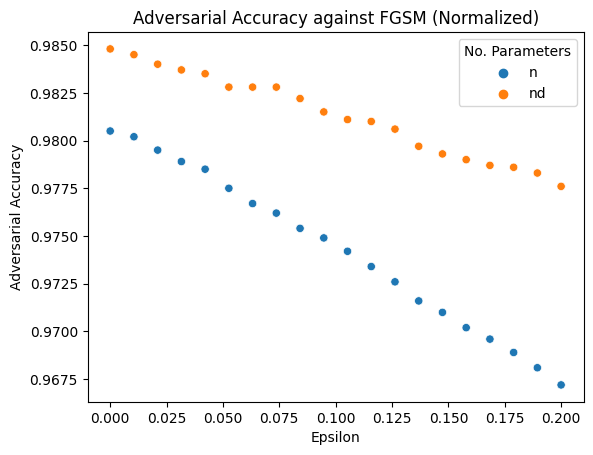

In [ ]:
data = pd.DataFrame({ 'n': acc_minimal, 'nd': acc_nd, 'epsilon': epsilons })

data_melted = data.melt(id_vars='epsilon', var_name='No. Parameters', value_name='Adversarial Accuracy')

sns.scatterplot(data=data_melted, y='Adversarial Accuracy', x='epsilon', hue='No. Parameters')

plt.xlabel('Epsilon')
plt.ylabel('Adversarial Accuracy')
plt.title('Adversarial Accuracy against FGSM (Normalized)')

plt.show()

## Test Models agaist $\tt{mnist\_corrupted}$ dataset

In [ ]:
import tensorflow_datasets as tfds

In [ ]:

corruption_names = ['identity', 'shot_noise', 'impulse_noise', 'glass_blur', 'motion_blur', 'shear', 'scale', 'rotate', 'brightness', 'translate', 'stripe', 'fog', 'spatter', 'dotted_line', 'zigzag', 'canny_edges']

accuracy_corrupted_nd = []
accuracy_corrupted_minimal = []


for name in corruption_names:
    print(f"Evaluating on {name}")
    # Load the corrupted MNIST dataset
    corrupted_mnist_builder = tfds.builder('mnist_corrupted/'+ name)
    corrupted_mnist_builder.download_and_prepare()
    test_dataset = tfds.load('mnist_corrupted/'+ name, split='test', as_supervised=True)

    # The MNIST images are in the range [0, 255], so normalize them to the range [0, 1]
    test_dataset = test_dataset.map(lambda img, label: (tf.cast(img, tf.float64) / 255., tf.one_hot(label, depth=10)))

    # Evaluate the model on the test dataset
    test_loss_nd, test_accuracy_nd = mnistnd.evaluate(test_dataset.batch(128))
    test_loss_minimal, test_accuracy_minimal = mnistminimal.evaluate(test_dataset.batch(128))
    accuracy_corrupted_nd.append(test_accuracy_nd)
    accuracy_corrupted_minimal.append(test_accuracy_minimal)
    print(f"Test loss ND: {test_loss_nd}")
    print(f"Test accuracy ND: {test_accuracy_nd}")
    print(f"Test loss minimal: {test_loss_minimal}")
    print(f"Test accuracy minimal: {test_accuracy_minimal}")


Evaluating on identity


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incompleteI0KCTM/mnist_corrupted-train.tfre…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0.incompleteI0KCTM/mnist_corrupted-test.tfrec…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/identity/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 0.2114 - accuracy: 0.9805
Test loss ND: 0.5865221619606018
Test accuracy ND: 0.9847999811172485
Test loss minimal: 0.21136921644210815
Test accuracy minimal: 0.9804999828338623
Evaluating on shot_noise


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shot_noise/1.0.0.incompleteJI98N6/mnist_corrupted-train.tf…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shot_noise/1.0.0.incompleteJI98N6/mnist_corrupted-test.tfr…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/shot_noise/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.9711
Test loss ND: 0.676079511642456
Test accuracy ND: 0.9767000079154968
Test loss minimal: 0.2681223452091217
Test accuracy minimal: 0.9710999727249146
Evaluating on impulse_noise


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/impulse_noise/1.0.0.incompleteG44ZGZ/mnist_corrupted-train…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/impulse_noise/1.0.0.incompleteG44ZGZ/mnist_corrupted-test.…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/impulse_noise/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 4.0643 - accuracy: 0.7474
Test loss ND: 2.318509817123413
Test accuracy ND: 0.8986999988555908
Test loss minimal: 4.06430196762085
Test accuracy minimal: 0.7473999857902527
Evaluating on glass_blur


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/glass_blur/1.0.0.incompleteRO6ECL/mnist_corrupted-train.tf…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/glass_blur/1.0.0.incompleteRO6ECL/mnist_corrupted-test.tfr…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/glass_blur/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 0.3544 - accuracy: 0.9482
Test loss ND: 1.010776400566101
Test accuracy ND: 0.9416999816894531
Test loss minimal: 0.3543629050254822
Test accuracy minimal: 0.948199987411499
Evaluating on motion_blur


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/motion_blur/1.0.0.incompleteN79K9Q/mnist_corrupted-train.t…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/motion_blur/1.0.0.incompleteN79K9Q/mnist_corrupted-test.tf…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/motion_blur/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 1.8194 - accuracy: 0.8387
Test loss ND: 3.669144630432129
Test accuracy ND: 0.847000002861023
Test loss minimal: 1.8194172382354736
Test accuracy minimal: 0.838699996471405
Evaluating on shear


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shear/1.0.0.incompleteF8VJ2Q/mnist_corrupted-train.tfrecor…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/shear/1.0.0.incompleteF8VJ2Q/mnist_corrupted-test.tfrecord…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/shear/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 1.0334 - accuracy: 0.9288
Test loss ND: 2.1271510124206543
Test accuracy ND: 0.9532999992370605
Test loss minimal: 1.0334020853042603
Test accuracy minimal: 0.9287999868392944
Evaluating on scale


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/scale/1.0.0.incompleteFD69H0/mnist_corrupted-train.tfrecor…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/scale/1.0.0.incompleteFD69H0/mnist_corrupted-test.tfrecord…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/scale/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 4.3736 - accuracy: 0.6788
Test loss ND: 9.717079162597656
Test accuracy ND: 0.7509999871253967
Test loss minimal: 4.373598575592041
Test accuracy minimal: 0.6787999868392944
Evaluating on rotate


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/rotate/1.0.0.incompleteQ71P74/mnist_corrupted-train.tfreco…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/rotate/1.0.0.incompleteQ71P74/mnist_corrupted-test.tfrecor…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/rotate/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 2.4109 - accuracy: 0.8511
Test loss ND: 6.603609561920166
Test accuracy ND: 0.8741999864578247
Test loss minimal: 2.4108715057373047
Test accuracy minimal: 0.8511000275611877
Evaluating on brightness


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/brightness/1.0.0.incompleteUEARVG/mnist_corrupted-train.tf…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/brightness/1.0.0.incompleteUEARVG/mnist_corrupted-test.tfr…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/brightness/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 40.3428 - accuracy: 0.2294
Test loss ND: 37.77893829345703
Test accuracy ND: 0.1501999944448471
Test loss minimal: 40.342803955078125
Test accuracy minimal: 0.22939999401569366
Evaluating on translate


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/translate/1.0.0.incomplete6NHJ31/mnist_corrupted-train.tfr…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/translate/1.0.0.incomplete6NHJ31/mnist_corrupted-test.tfre…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/translate/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 27.3999 - accuracy: 0.3029
Test loss ND: 62.407894134521484
Test accuracy ND: 0.361299991607666
Test loss minimal: 27.399906158447266
Test accuracy minimal: 0.3028999865055084
Evaluating on stripe


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/stripe/1.0.0.incomplete7CU6CX/mnist_corrupted-train.tfreco…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/stripe/1.0.0.incomplete7CU6CX/mnist_corrupted-test.tfrecor…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/stripe/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 116.5264 - accuracy: 0.1591
Test loss ND: 76.83126068115234
Test accuracy ND: 0.3695000112056732
Test loss minimal: 116.52635955810547
Test accuracy minimal: 0.1590999960899353
Evaluating on fog


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/fog/1.0.0.incompleteOQNCAZ/mnist_corrupted-train.tfrecord*…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/fog/1.0.0.incompleteOQNCAZ/mnist_corrupted-test.tfrecord*.…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/fog/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 36.4904 - accuracy: 0.1808
Test loss ND: 32.26518630981445
Test accuracy ND: 0.12800000607967377
Test loss minimal: 36.49043273925781
Test accuracy minimal: 0.18080000579357147
Evaluating on spatter


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/spatter/1.0.0.incompleteJDTL2X/mnist_corrupted-train.tfrec…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/spatter/1.0.0.incompleteJDTL2X/mnist_corrupted-test.tfreco…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/spatter/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 0.7761 - accuracy: 0.9262
Test loss ND: 1.1151185035705566
Test accuracy ND: 0.9613000154495239
Test loss minimal: 0.7761472463607788
Test accuracy minimal: 0.9261999726295471
Evaluating on dotted_line


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/dotted_line/1.0.0.incomplete8CTYQ1/mnist_corrupted-train.t…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/dotted_line/1.0.0.incomplete8CTYQ1/mnist_corrupted-test.tf…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/dotted_line/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 1.3113 - accuracy: 0.8892
Test loss ND: 1.2474147081375122
Test accuracy ND: 0.9574999809265137
Test loss minimal: 1.3112893104553223
Test accuracy minimal: 0.88919997215271
Evaluating on zigzag


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/zigzag/1.0.0.incompleteROQU34/mnist_corrupted-train.tfreco…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/zigzag/1.0.0.incompleteROQU34/mnist_corrupted-test.tfrecor…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/zigzag/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 2ms/step - loss: 7.3533 - accuracy: 0.6801
Test loss ND: 7.218961715698242
Test accuracy ND: 0.8185999989509583
Test loss minimal: 7.353307723999023
Test accuracy minimal: 0.6801000237464905
Evaluating on canny_edges


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/canny_edges/1.0.0.incompleteZRB828/mnist_corrupted-train.t…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist_corrupted/canny_edges/1.0.0.incompleteZRB828/mnist_corrupted-test.tf…

Dataset mnist_corrupted downloaded and prepared to /root/tensorflow_datasets/mnist_corrupted/canny_edges/1.0.0. Subsequent calls will reuse this data.
79/79 [==============================] - 0s 3ms/step - loss: 4.3892 - accuracy: 0.6534
Test loss ND: 12.255851745605469
Test accuracy ND: 0.6743999719619751
Test loss minimal: 4.389202117919922
Test accuracy minimal: 0.6534000039100647


In [ ]:

print(f"Corruption:{corruption_names}")
print(f"Test Accuracy nd:{accuracy_corrupted_nd}")
print(f"Test Accuracy minimal:{accuracy_corrupted_minimal}")

Corruption:['identity', 'shot_noise', 'impulse_noise', 'glass_blur', 'motion_blur', 'shear', 'scale', 'rotate', 'brightness', 'translate', 'stripe', 'fog', 'spatter', 'dotted_line', 'zigzag', 'canny_edges']
Test Accuracy nd:[0.9847999811172485, 0.9767000079154968, 0.8986999988555908, 0.9416999816894531, 0.847000002861023, 0.9532999992370605, 0.7508999705314636, 0.8741999864578247, 0.15029999613761902, 0.3614000082015991, 0.3695000112056732, 0.12800000607967377, 0.9613000154495239, 0.9574999809265137, 0.8185999989509583, 0.6743999719619751]
Test Accuracy minimal:[0.9804999828338623, 0.9710999727249146, 0.7473999857902527, 0.9480999708175659, 0.8388000130653381, 0.9287999868392944, 0.6787999868392944, 0.8511000275611877, 0.22949999570846558, 0.3028999865055084, 0.1590999960899353, 0.18070000410079956, 0.9261000156402588, 0.8892999887466431, 0.6801000237464905, 0.6532999873161316]


In [ ]:
!pip install tabulate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tabulate import tabulate

table = list(zip(corruption_names, accuracy_corrupted_nd, accuracy_corrupted_minimal))
headers = ["Corruption Names", "Accuracy Corrupted ND", "Accuracy Corrupted Minimal"]
latex_table = tabulate(table, headers, tablefmt="latex")

print(latex_table)


\begin{tabular}{lrr}
\hline
 Corruption Names   &   Accuracy Corrupted ND &   Accuracy Corrupted Minimal \\
\hline
 identity           &                  0.9848 &                       0.9805 \\
 shot\_noise         &                  0.9767 &                       0.9711 \\
 impulse\_noise      &                  0.8987 &                       0.7474 \\
 glass\_blur         &                  0.9417 &                       0.9481 \\
 motion\_blur        &                  0.847  &                       0.8388 \\
 shear              &                  0.9533 &                       0.9288 \\
 scale              &                  0.7509 &                       0.6788 \\
 rotate             &                  0.8742 &                       0.8511 \\
 brightness         &                  0.1503 &                       0.2295 \\
 translate          &                  0.3614 &                       0.3029 \\
 stripe             &                  0.3695 &                       0.1591 \\
 

In [ ]:
count = sum(nd > minimal for nd, minimal in zip(accuracy_corrupted_nd, accuracy_corrupted_minimal))

print(count)##with the number of corruptions equal to 16


13


## Other adversarial attacks